In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input, MultiHeadAttention, Dropout, Concatenate,LayerNormalization
import tensorflow_addons as tfa  # thư viện cho Attention
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Input, Attention,concatenate
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

C:\Users\57\AppData\Roaming\Python\Python39\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\57\AppData\Roaming\Python\Python39\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issu

In [2]:
data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\train_data2.csv') 
data.set_index('Ngay', inplace=True)
print(data)

            mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
Ngay                                                                     
01/01/2008        120        498.815         259.499               0.0   
02/01/2008        117        470.866         518.755               0.0   
03/01/2008        139        423.816         615.242               0.0   
04/01/2008        166        496.882         902.982               0.0   
05/01/2008        179        501.232        1072.970               0.0   
...               ...            ...             ...               ...   
27/12/2014        111        482.000         355.000             111.7   
28/12/2014        108        442.000         386.000              95.6   
29/12/2014         84        268.000         474.000             119.7   
30/12/2014         80        543.000         345.000             104.7   
31/12/2014         77        812.000         380.590             101.0   

            chayMayTuyenQuan  nuocVeT

In [3]:
# Chuẩn hóa dữ liệu để đưa về khoảng [0, 1] để dễ xử lý khi đưa vào mô hình
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [4]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0])  # 'mucNuocHN' là cột đầu tiên
    return np.array(sequences), np.array(targets)


In [5]:
sequence_length = 2 # Sử dụng số ngày trước để dự báo ngày tiếp theo
X, y = create_sequences(data_scaled, sequence_length)
X_train_decoded = []
# Loop through each sequence in X_train
for i in range(X.shape[0]):
    # Reshape each sequence to 2D, apply inverse transform, and add to the decoded list
    original_values = scaler.inverse_transform(X[i])
    X_train_decoded.append(original_values)
X_train_decoded = np.array(X_train_decoded)
print(X_train_decoded)

# Tạo mảng giả có cùng số cột với dữ liệu ban đầu
dummy_array = np.zeros((y.shape[0], data_scaled.shape[1]))
dummy_array[:, 0] = y.flatten()  # Chỉ đặt giá trị `y` vào cột đầu tiên

# Giải mã bằng scaler
decoded_array = scaler.inverse_transform(dummy_array)

# Lấy lại cột đầu tiên (giá trị giải mã của `y`)
y_decoded = decoded_array[:, 0]

# In kết quả
print(y_decoded)



[[[120.    498.815 259.499 ...   0.     23.23   90.2  ]
  [117.    470.866 518.755 ...   0.     26.239 213.791]]

 [[117.    470.866 518.755 ...   0.     26.239 213.791]
  [139.    423.816 615.242 ...   0.     24.    175.   ]]

 [[139.    423.816 615.242 ...   0.     24.    175.   ]
  [166.    496.882 902.982 ...   0.     11.    164.   ]]

 ...

 [[111.    482.    355.    ... 118.251  95.65   85.65 ]
  [108.    442.    386.    ...  58.377 119.589   0.   ]]

 [[108.    442.    386.    ...  58.377 119.589   0.   ]
  [ 84.    268.    474.    ...  94.274  95.65   85.65 ]]

 [[ 84.    268.    474.    ...  94.274  95.65   85.65 ]
  [ 80.    543.    345.    ... 115.226 113.294  75.867]]]
[139. 166. 179. ...  84.  80.  77.]


In [6]:
# sequence_length = 1 # Sử dụng 30 ngày để dự đoán
# X, y = [], []
# for i in range(sequence_length, len(data_scaled)):
#     X.append(data_scaled[i-sequence_length:i])
#     y.append(data_scaled[i])

# X, y = np.array(X), np.array(y)

In [7]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(X_train.shape[1])

2


In [8]:
# LSTM lớp ẩn
input_layer = Input(shape=(sequence_length, X_train.shape[2]))
lstm_out = LSTM(64, activation='relu', return_sequences=True)(input_layer)
attention_out = MultiHeadAttention(num_heads=15, key_dim=64)(lstm_out, lstm_out)
concat_output = Concatenate()([lstm_out, attention_out])
# Lớp Attention
dropout_layer = Dropout(0.1)(concat_output)
lstm_out_attention = LSTM(32)(dropout_layer)
# Lớp đầu ra
output = Dense(1)(lstm_out_attention)


In [9]:
# Khởi tạo và biên dịch mô hình
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2, 7)]               0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 2, 64)                18432     ['input_1[0][0]']             
                                                                                                  
 multi_head_attention (Mult  (None, 2, 64)                248704    ['lstm[0][0]',                
 iHeadAttention)                                                     'lstm[0][0]']                
                                                                                                  
 concatenate (Concatenate)   (None, 2, 128)               0         ['lstm[0][0]',           

In [10]:
# 3. Huấn luyện mô hình
history = model.fit(X_train,y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50

64/64 [==============================] - 6s 28ms/step - loss: 0.0102 - val_loss: 0.0014
Epoch 2/50
64/64 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 3/50
64/64 [==============================] - 1s 10ms/step - loss: 9.9460e-04 - val_loss: 0.0013
Epoch 4/50
64/64 [==============================] - 1s 10ms/step - loss: 9.5343e-04 - val_loss: 0.0025
Epoch 5/50
64/64 [==============================] - 1s 10ms/step - loss: 9.6712e-04 - val_loss: 0.0011
Epoch 6/50
64/64 [==============================] - 1s 12ms/step - loss: 8.8762e-04 - val_loss: 0.0010
Epoch 7/50
64/64 [==============================] - 1s 11ms/step - loss: 7.8156e-04 - val_loss: 9.0071e-04
Epoch 8/50
64/64 [==============================] - 1s 11ms/step - loss: 8.4696e-04 - val_loss: 8.8556e-04
Epoch 9/50
64/64 [==============================] - 1s 13ms/step - loss: 9.9796e-04 - val_loss: 6.8373e-04
Epoch 10/50
64/64 [==============================] - 1s 15ms/step - 

In [11]:
def nse(y_true, y_pred):
    return 1 - sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2)

In [12]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R² (R-squared):", r2)

# Tính NSE
nse_value = nse(y_test.flatten(), y_pred.flatten())
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

# Tính MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

16/16 [==============================] - 3s 13ms/step
R² (R-squared): 0.9696718091150319
Nash-Sutcliffe Efficiency (NSE): 0.9696718091150318
Mean Absolute Error (MAE): 0.015588086485296993
Root Mean Squared Error (RMSE): 0.021251275708550517


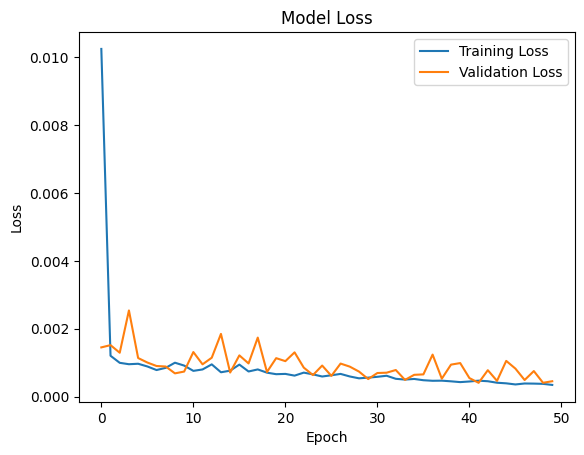

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# 5. Vẽ đồ thị dự báo so sánh với thực tế cho từng mực nước
new_data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\test_data2_1.csv') 
new_data['Ngay'] = pd.to_datetime(new_data['Ngay'], format='%d/%m/%Y')
new_data.set_index('Ngay', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(new_data)

In [15]:
dates = new_data.columns
print(dates)

Index(['mucNuocHN', 'nuocVeHoaBinh', 'chayMayHoaBinh', 'nuocVeTuyenQuang',
       'chayMayTuyenQuan', 'nuocVeThacBa', 'chayMayThacBa'],
      dtype='object')


In [16]:
new_data_scaled = scaler.transform(new_data)  # Sử dụng scaler đã huấn luyện từ dữ liệu ban đầu

# Chia dữ liệu mới thành chuỗi thời gian
X_test_new, y_test_new = create_sequences(new_data_scaled, sequence_length)
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], X_test_new.shape[2]))

predictions_new = model.predict(X_test_new)
num_columns = new_data_scaled.shape[1]
print(num_columns)
predictions_new_original = scaler.inverse_transform(
    np.concatenate((predictions_new, np.zeros((predictions_new.shape[0], num_columns - predictions_new.shape[1]))), axis=1)
)[:, 0]

# Thêm đủ các cột phụ vào y_test_new để khớp với số cột của scaler
y_test_new_original = scaler.inverse_transform(
    np.concatenate((y_test_new.reshape(-1, 1), np.zeros((y_test_new.shape[0], num_columns - 1))), axis=1)
)[:, 0]

23/23 [==============================] - 0s 10ms/step
7


In [17]:
# predictions = model.predict(X_new)
# predictions_new_original = scaler.inverse_transform(predictions)[:,0]
# y_test_new_original = scaler.inverse_transform(y_new)[:,0]

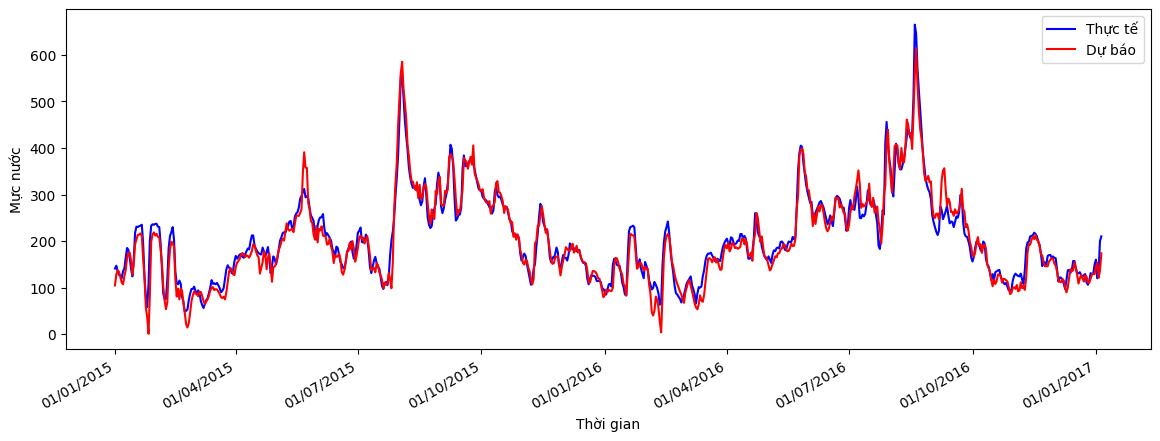

In [18]:
# Đảm bảo các mảng có cùng kích thước
import matplotlib.dates as mdates 
min_length = min(len(new_data.index), len(y_test_new_original), len(predictions_new_original))

# Cắt ngắn mảng theo độ dài nhỏ nhất
dates = new_data.index[:min_length]
y_test_new_original = y_test_new_original[:min_length]
predictions_new_original = predictions_new_original[:min_length]

# Vẽ biểu đồ
plt.figure(figsize=(14, 5))
plt.plot(dates, y_test_new_original, label='Thực tế', color='blue')
plt.plot(dates, predictions_new_original, label='Dự báo', color='red')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước')

# Định dạng ngày tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()


In [19]:
# Tạo mảng ngày bắt đầu từ chỉ số sequence_length của new_data
dates = new_data.index[sequence_length:]

# Đảm bảo số lượng phần tử của dự báo và thực tế khớp với số lượng ngày
min_length = min(len(dates), len(predictions_new_original), len(y_test_new_original))

# Cắt ngắn các mảng để khớp số phần tử nếu cần
dates = dates[:min_length]
predictions_new_original = predictions_new_original[:min_length]
y_test_new_original = y_test_new_original[:min_length]

# Tạo DataFrame với ngày, thực tế và dự báo
df_mucNuocHN = pd.DataFrame({
    'Ngay': dates,
    'ThucTe': y_test_new_original,
    'DuBao': predictions_new_original
})

# Đặt cột 'Ngay' làm chỉ mục
df_mucNuocHN.set_index('Ngay', inplace=True)

# Đặt tên đa cấp cho các cột với nhóm 'mucNuocHaNoi'
df_mucNuocHN.columns = pd.MultiIndex.from_product([['mucNuocHaNoi'], ['ThucTe', 'DuBao']])

# Hiển thị DataFrame
print(df_mucNuocHN)


           mucNuocHaNoi            
                 ThucTe       DuBao
Ngay                               
2015-01-03        141.0  104.670915
2015-01-04        147.0  128.145179
2015-01-05        135.0  136.883522
2015-01-06        127.0  133.945261
2015-01-07        126.0  123.001624
...                 ...         ...
2017-01-03        160.0  144.491782
2017-01-04        120.0  153.253174
2017-01-05        140.0  121.260966
2017-01-06        200.0  136.567248
2017-01-07        210.0  173.594053

[736 rows x 2 columns]
